# Congestión

En este documento se realizara un dataframe en el cual se tendran los tiempos de viaje, hora de salida y de llegada de cada viaje para primero contar, en una determinada hora (tengo metido en la cabeza a las 6 am XD) cuantas personas no han llegado a sus destinos, como una primera medida de congestion y revisar esto mediante un intervalo, el cual yo considero minimo de media hoa, aunque eso debe tener un argumento mas fuerte como la demora promedio por viaje.

Antes de esto se deben conocer cantidades determinantes como la demora promedio de todos los viajes, y tambien podria ser una medida de congestion medir este paramertro dependiendo de la hora, y estas cantidades habra que norlmalizarlas, pero con respecto a que???? no estoy seguro pero a medida que avance el problema y hablando con Hurtado lo averiguare. 

In [ ]:
#Se llaman las librerias necesarias
import pandas as pd
import numpy as np
import networkx as nx 
import matplotlib.pyplot as plt
import operator
import itertools
import datetime
from scipy.optimize import curve_fit

In [ ]:
# Se importa la base de datos necesaria parael problema
great_df = pd.read_csv('Viajes_en_Bogota.csv')
great_df.head()

## Funciones importantes 

In [68]:
# Cuenta la cantidad de un elemento sobre todos los elementos de un arreglo 
def count(array):
    y_dist = np.asarray([list(array).count(x) for x in np.unique(array)])
    x_dist = np.asarray([x for x in np.unique(array)])
    return x_dist, y_dist

#Cambia los datos de hora a tipo datatime 
def to_time(clmn):
    array = []
    for i in clmn:
        array.append(datetime.datetime.strptime(i, '%H:%M:%S').time())
    return array

# Funcion en la que se aplica el metodo de newman
def newman(array):
    my_array = []
    for i in range(len(array)):
        P = sum(array[i:])
        my_array.append(P)
    return my_array

### Analisis y distribucion de la duracion de los tiempos de viaje en la red

In [ ]:
great_df['duracion'].agg('average')

El tiempo promedio de viajes para la red de Bogotá y Suacha es $\bar{t} = 50,08$ minutos

In [ ]:
great_df[['hora_inicio_viaje','p10v_hora_salida', 'hora_llegada', 'duracion']]

In [70]:
duracion = np.asarray(great_df[great_df['duracion'] <= 200]['duracion'])
duracion_x, duracion_y = count(duracion) 
y_normal = duracion_y/sum(duracion_y)
dur_newman = newman(y_normal)

In [67]:
np.mean(duracion)

44.88990374414074

In [21]:
sum(np.asarray(great_df['duracion']))

5282847

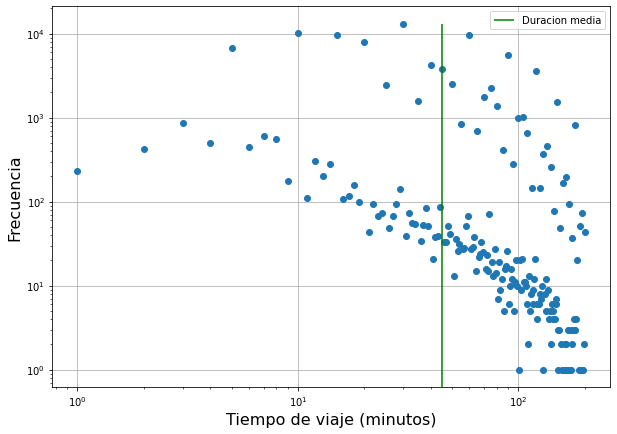

In [32]:
# Distribucion 
plt.figure(figsize = (10,7))
plt.loglog(duracion_x, duracion_y, 'o')
plt.xlabel('Tiempo de viaje (minutos)', fontsize = 16)
plt.ylabel('Frecuencia', fontsize = 16)
plt.vlines(np.mean(duracion), 0, 1.3e4, color = 'g',label = 'Duracion media')
plt.legend()
plt.grid()

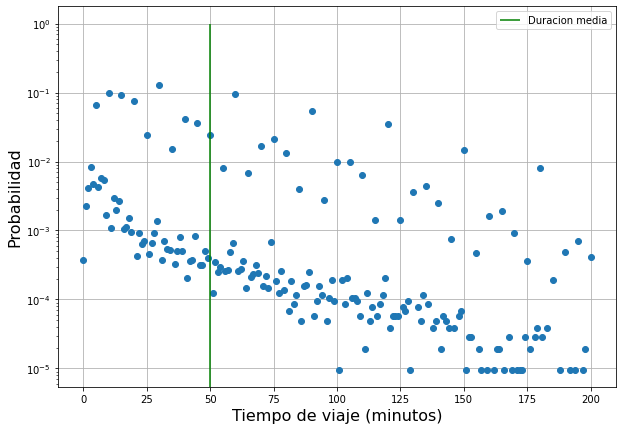

In [77]:
plt.figure(figsize = (10,7))
plt.semilogy(duracion_x, y_normal, 'o')
plt.xlabel('Tiempo de viaje (minutos)', fontsize = 16)
plt.ylabel('Probabilidad', fontsize = 16)
plt.vlines(great_df['duracion'].agg('average'), 0, 1, color = 'g',label = 'Duracion media')
plt.legend()
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


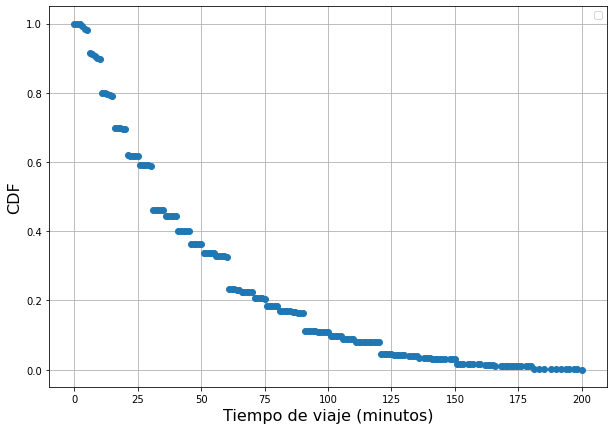

In [78]:
plt.figure(figsize = (10,7))
plt.plot(duracion_x, dur_newman, 'o')
plt.xlabel('Tiempo de viaje (minutos)', fontsize = 16)
plt.ylabel('CDF', fontsize = 16)
#plt.vlines(great_df['duracion'].agg('average'), 0, 1, color = 'g',label = 'Duracion media')
plt.legend()
plt.grid()

Hay algo que me inquieta a la hora de ver la distribucion de la duracion de los viajes y es la presencia de tres estructuras aparentemente independientes, en donde cada una sigue una tendencia por separado, y no una tendencia global, e incluso, dependiendo de como se vea, se pueden incluso ver cuatro estructuras en esta grafica, lo cual es inquietante.

Algo que se puede hacer con la duracion de los viajes es por medio de tranporte, localidad (considerando a soacha una localidad) y por estrato a ver como se comporta esa joda.

In [ ]:
great_df[great_df['duracion'] < 200][['hora_inicio_viaje','p10v_hora_salida', 'hora_llegada', 'duracion', 'zat_origen', 'zat_destino']]

Revisando la duracion de los viajes se notan cosas raras, como el hecho de que excisten viajes cuya duracion es $t = 0$, y son viajes entre zonas bastante separadas, o casos tambien mas raros en donde la duracion es algo absurdo, como mas de 1000 minutos. Hay unos viajes que duran mas o menos 12 horas, van y llegan al mismo lado, podria decirse que es casi que el viaje de la casa al trabajo y de regreso XD.

Teniendo en cuenta estos dos extremos atipicos me planteo la gran posibilidad de filtrar tambien estos datos de mi base de datos, la gracia seria consultarlo con hurtado.

In [ ]:
len(great_df)*98/100

Entre el 87% y el 88% los viajes duran menos de 100 munitos, es decir, mas de una hora y media, por lo cual, tan solo un 13% de los viajes duran mas que esto, los cuales son relativamente pocos, pero es totalmente plausible que los viajes puedan durar hasta tres horas dentro de la ciudad. Los viajes que duran menos de 200 minutos, tres horas y 20 minutos representan entre 98 y 99% de los viajes realizados, por lo cual esto podria tomarse como una cota superior para el filtrado de los datos, ya que esos datos de al rededor de doce horas es casi que ir y volver de la casa, seria ver el lugar de origen o el motivo de estos viajes para ver las rarezas ocultas de estos. 

Al hacerle el proceso de Newman se nota que la distribucion de las duraciones sigue aproximadamente una ley exponencilal, quien lo diria XD

A partir de aca se va a ahcer la serie de tiempo de la duracion de viaje promedio

In [17]:
df_duracion = great_df[['hora_inicio_viaje', 'hora_llegada', 'duracion']]
df_duracion = df_duracion[df_duracion['duracion'] <= 200]
df_duracion['hora_inicio_viaje'] = to_time(df_duracion['hora_inicio_viaje'])
df_duracion['hora_llegada'] = to_time(df_duracion['hora_llegada'])

In [27]:
df_duracion['duracion'].agg('average')

44.88990374414074

In [47]:
horas = []
dur_media = []
num_viajes = []
hora = datetime.time(0, 0)
hora_out = datetime.time(22, 0)
hora_in = datetime.time(2,0)
df = df_duracion[(df_duracion['hora_inicio_viaje'] >= hora_out) & 
             (df_duracion['hora_llegada'] <= hora_in) &
             (df_duracion['hora_inicio_viaje'] <= datetime.time(23, 59)) & 
             (df_duracion['hora_llegada'] >= hora)]
dur_media.append(df['duracion'].agg('average'))
horas.append(0)
num_viajes.append(len(df))
for i in range(1,24):
    hora = datetime.time(i, 0)
    df = df_duracion[(df_duracion['hora_inicio_viaje'] <= hora) & (df_duracion['hora_llegada'] >= hora)]
    dur_media.append(df['duracion'].agg('average'))
    horas.append(i)
    num_viajes.append(len(df))

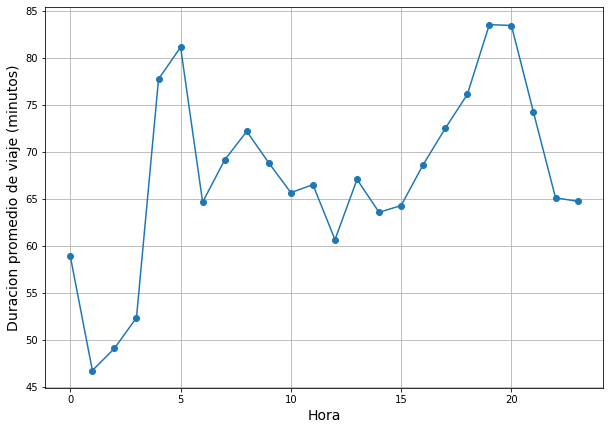

In [52]:
plt.figure(figsize = (10, 7))
plt.plot(horas, dur_media, 'o', linestyle = '-')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Duracion promedio de viaje (minutos)', fontsize = 14)
plt.grid()

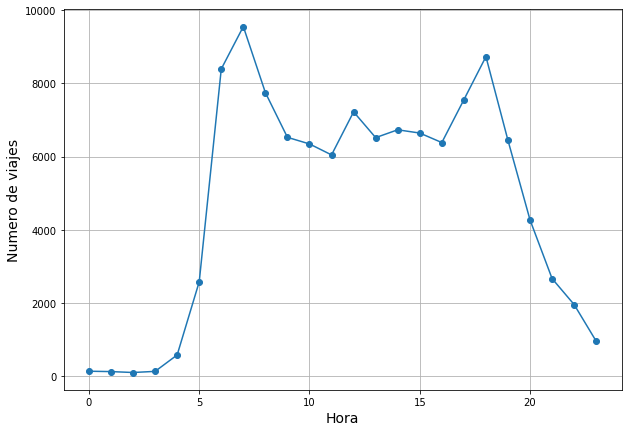

In [51]:
plt.figure(figsize = (10, 7))
plt.plot(horas, num_viajes, 'o', linestyle = '-')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Numero de viajes', fontsize = 14)
plt.grid()

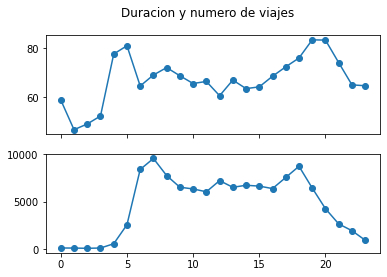

In [62]:
fig, axs = plt.subplots(2, sharex = True)
fig.suptitle('Duracion y numero de viajes')
axs[0].plot(horas, dur_media, 'o', linestyle = '-')
axs[1].plot(horas, num_viajes, 'o', linestyle = '-')


Basicamente todas estas cantidades siguen mas o menos el mismo tipo de estructura de horas pico y valle, podria concluirse que esta dinamica es la que rige la estructura de la movilidad de bogota. Para el caso particular de la duracion promedio de los viajes, se ve que las horas mas congestionadas son las horas pico, pero para este caso la hora pico parce desplazarse, como se ve, los viajes que se hacen entre 4 y 5 de la mañana duran muchisimo, al igual que los hechos entre 7 y 8 de la noche, como si los picos se hubieran movido a los extremos. Esto quiere decir que los pocos viajes que se hacen a las 4 y a las 5, estos duran un monton, pero tocaria ver de donde a donde son estos viajes y normalizarlos de mas que por la distancia, o ver si se dan fenomenos de congestion locales, de igual manera a las 8 de la noche ya bajo el numero de viajes que se hacen, peeeroooooo los que se estan haciendo duran muchiiisiiiimoooooo.

Se dan fenomenos muy curiosos, por ejemplo a las 6 de la mañana esta viajando un jurgo de gente, peeeroooo la duracion de los viajes no es tan grande, se va de pa abajo, incluso a las 7 de la mañana, en donde esta el maximo de viajes, la duracion de los viajes es de un poco mas de una hora. 

Un analisis completo de esto vendria cuando se tengan las distancias geograficas (mas o menos XD) porque estoy cerca, pero aun no se ve la congestion 

### Base de datos exclusiva para analisis de congestion

Se creara un archivo csv separado el cual contenga todos los detalles con respecto a las horas y duracion de los viajes para hacer mas eficiente el conteo y medicion de fenomenos de congestion.

In [ ]:
great_df[great_df['hora_inicio_viaje'] == '06:00:00']

In [ ]:
date_time_str = '2018-06-29 08:15:27.243860'
date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S.%f')

print('Date:', date_time_obj.date())
print('Time:', date_time_obj.time())
print('Date-time:', date_time_obj)

In [ ]:
to_time(great_df['hora_inicio_viaje'])

In [36]:
cng_df = great_df[['id_hogar', 'p5_estrato', 'p17_Id_motivo_viaje', 'zat_origen', 'zat_destino', 'hora_inicio_viaje', 'hora_llegada', 'duracion', 'modo_principal']]

In [37]:
cng_df['hora_inicio_viaje'] = to_time(cng_df['hora_inicio_viaje'])
cng_df['hora_llegada'] = to_time(cng_df['hora_llegada'])
cng_df

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id_hogar,p5_estrato,p17_Id_motivo_viaje,zat_origen,zat_destino,hora_inicio_viaje,hora_llegada,duracion,modo_principal
0,17081,1,1,1141.0,225.0,18:00:00,18:10:00,10,TransMilenio
1,17081,1,6,225.0,1141.0,06:00:00,06:10:00,10,TransMilenio
2,17081,1,10,1141.0,477.0,15:30:00,16:15:00,45,A pie
3,17081,1,6,477.0,1141.0,06:20:00,06:25:00,5,A pie
4,P07096,1,7,1141.0,14.0,12:00:00,20:00:00,480,A pie
...,...,...,...,...,...,...,...,...,...
105471,P02949,1,3,765.0,765.0,06:20:00,06:50:00,30,Bicicleta
105472,P02949,1,6,765.0,765.0,16:00:00,17:10:00,70,A pie
105473,P02949,1,16,765.0,766.0,12:45:00,14:00:00,75,Transporte informal
105474,P02950,1,6,774.0,765.0,13:30:00,13:36:00,6,A pie


In [ ]:
cng_df.to_csv('Congestion_en_Bogota.csv')

## Algoritmo de congestion

Aca se haran ciertos intentos para medir la congestion como tal, la primera manera de medir esta cantidad es a partir de contar cuantas personas estan transitando la red en un determinado intervalo de tiempo, como se hace en el articulo de *Echenique, P., Gómez-Gardenes, J., & Moreno, Y. (2005)* 

In [35]:
# Primer experimento de congestion
# Aislamos las columnas pertinentes
horas_df = cng_df[['hora_inicio_viaje', 'hora_llegada']]
horas_df.head()

,hora_inicio_viaje,hora_llegada
0,18:00:00,18:10:00
1,06:00:00,06:10:00
2,15:30:00,16:15:00
3,06:20:00,06:25:00
4,12:00:00,20:00:00


In [39]:
suma = 0
hora1 = datetime.time(11, 30)
hora2 = datetime.time(12, 30)
for i in range(len(horas_df)):
    #a = horas_df.iloc[i][0]
    b = horas_df.iloc[i][1]
    if b > hora1 and b < hora2:
        suma += 1
suma

6038

In [40]:
hora3 = datetime.time(7, 0)
suma1 = 0
for i in range(len(horas_df)):
    a = horas_df.iloc[i][0]
    b = horas_df.iloc[i][1]
    if a < hora3 and b > hora3:
        suma1 += 1
suma1

4588

In [42]:
len(horas_df[(horas_df['hora_inicio_viaje'] < hora3) & (horas_df['hora_llegada'] > hora3)])

4588

In [ ]:
# Cantidad de viajes hechos en una hora determinada
num_viajes = []
horas = []
for i in range(0,24):
    hora = datetime.time(i,0)
    horas.append(hora)
    suma = 0
    for j in range (len(horas_df)):
        a = horas_df.iloc[j][0]
        b = horas_df.iloc[j][1]
        if a < hora and b > hora:
            suma += 1
    num_viajes.append(suma)

In [ ]:
horas = np.asarray([x for x in range(24)])
num_viajes = np.asarray(num_viajes)
plt.figure(figsize = (11,7))
plt.plot(horas, num_viajes, marker = 'o', linestyle = '-')
plt.xlabel('Hora', fontsize = 14)
plt.ylabel('Numero de viajes', fontsize = 14)
plt.plot
plt.savefig('No_de_viajes_por-hora.pdf')

In [ ]:
cantidad_viajes = open("cantida_viajes.txt", "w")
np.savetxt(cantidad_viajes, num_viajes)
cantidad_viajes.close()

In [ ]:
a_file = open("test.txt", "w")
for row in an_array:
    np.savetxt(a_file, row)

a_file.close()

### Proximamente

Reviasar la distribucion de la duracion de los viajes ya que esas estructuras separadas son muy raras, tal vez algo que pueda ayudar es matar esos viajes todos peyes de 12 horas de duracion como esta comentado en dicha seccion.

Tambien se puede hacer un analisis mas profundo de la duracion y ver si esta se puede relacionar tambien de alguna forma con la congestion (seguramente si pero tocaria hacerlo con bastante cuidado)

Ya se logro contar la cantidad de viajes que se estan haciendo en un determinado intervalo de tiempo :3.

Ya lo que toca ir pensando es como se va a calcular el parametro de orden $\rho$

Ver como es el numero de viajes y la duracion de estos en funcion del modo de transporte y y el estrato, y estos datos toca normalizarlos sobre el numero de personas de cada estrato o del modo de tranporte, porque aja, el estrato dos y tres tendrian severos numeros y eso llevaria a las conclusiones incorrectas.

Analisar la duracion promedio de los viajes en funcion de la hora del dia y pues todos los parametros que se pueden estudiar.